# Tasks 1 Entropy and Information Gain

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./samplecar.csv")
data.head()

Type Price  Buy
0    SUV     H   No
1     HB     H   No
2     HB     H  Yes
3     HB     L   No
4  SEDAN     H  Yes

## Identify features and label and seperate it

In [3]:
features = data.iloc[:, :-1]
target = data.iloc[:,-1:]
# sanity check
assert features.shape[0] == target.shape[0], " len(features) == len(target)"

## Total Entropy for initial State

In [4]:
total = len(data)
tot_n = data[data["Buy"] == "No"].shape[0]
tot_y = data[data["Buy"] == "Yes"].shape[0]
prob_y = tot_y/total
prob_n = tot_n/total
print(prob_y, prob_n)
H_tot = -(prob_y * np.log2(prob_y) + prob_n * np.log2(prob_n))
print(H_tot)

0.6 0.4
0.9709505944546686


## Entropy for all the Attributes and combination

In [5]:
def calc_overal_info(data, split_value, split_col):
    i = 0
    info = 0
    total_len = len(data)
    for value in split_value:
        col = data[split_col == value]
        #print(col)
        col_len = len(col)
        tot_y = col[col["Buy"] == "Yes"].shape[0]
        tot_n = col[col["Buy"] == "No"].shape[0]
        if tot_y > 0 and tot_n > 0:
            prob_yes = tot_y/col_len
            prob_no = tot_n/col_len
            H_col = -(prob_yes * np.log2(prob_yes) + prob_no * np.log2(prob_no))       
            print(f'Entropy of {value}',H_tot - (H_col* col_len/total_len))  
            info += col_len/total_len * H_col
    return info

In [6]:
type_info = calc_overal_info(data, data["Type"].unique(), data["Type"])
IG = H_tot - type_info
print("Information gain from attribute Type:", IG)

Entropy of SUV 0.6954618442383217
Entropy of HB 0.5709505944546686
Information gain from attribute Type: 0.29546184423832167


In [7]:
price_info = calc_overal_info(data, data["Price"].unique(), data["Price"])
IG = H_tot - price_info
print("Information gain from attribute Price:", IG)

Entropy of H 0.4854752972273343
Entropy of L 0.5709505944546686
Information gain from attribute Price: 0.08547529722733427


# Task 2 Random Forest Regressor

In [8]:
data = pd.read_csv("./house_data.csv")
data.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  \
0  221900.0         3       1.00         1180      5650     1.0        1180   
1  538000.0         3       2.25         2570      7242     2.0        2170   
2  180000.0         2       1.00          770     10000     1.0         770   
3  604000.0         4       3.00         1960      5000     1.0        1050   
4  510000.0         3       2.00         1680      8080     1.0        1680   

   yr_built  
0      1955  
1      1951  
2      1933  
3      1965  
4      1987

In [9]:
data.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.157500e+04  21575.000000  21575.000000  21575.000000  2.157500e+04   
mean   5.383716e+05      3.369826      2.113105   2076.706373  1.509372e+04   
std    3.642894e+05      0.929871      0.769125    915.433561  4.144629e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.210000e+05      3.000000      1.750000   1420.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.611000e+03   
75%    6.412250e+05      4.000000      2.500000   2550.000000  1.066000e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    sqft_above      yr_built  
count  21575.000000  21575.000000  21575.000000  
mean       1.494276   1786.426559   1971.007416  
std        0.540089    826.457010     29.372485  
min        1.000000    290.000000   1900.000000  
25%        1.000000   1190.000000   1951.000000  
50%        1.500000   1560.000000   1975.000000  
75%        2.000000   2210.000000   1997.000000  
max        3.500000   9410.000000   2015.000000

### converting 'bathrooms' from float to int

In [10]:
data['bathrooms'] = data['bathrooms'].astype(int)

In [11]:
data["price"] = data['price'].div(100).round(2)

In [12]:
data.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  \
0  2219.0         3          1         1180      5650     1.0        1180   
1  5380.0         3          2         2570      7242     2.0        2170   
2  1800.0         2          1          770     10000     1.0         770   
3  6040.0         4          3         1960      5000     1.0        1050   
4  5100.0         3          2         1680      8080     1.0        1680   

   yr_built  
0      1955  
1      1951  
2      1933  
3      1965  
4      1987

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21575 entries, 0 to 21574
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21575 non-null  float64
 1   bedrooms     21575 non-null  int64  
 2   bathrooms    21575 non-null  int32  
 3   sqft_living  21575 non-null  int64  
 4   sqft_lot     21575 non-null  int64  
 5   floors       21575 non-null  float64
 6   sqft_above   21575 non-null  int64  
 7   yr_built     21575 non-null  int64  
dtypes: float64(2), int32(1), int64(5)
memory usage: 1.2 MB


In [14]:
# Feature and Target
feature = data.iloc[:,1:]
feature.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  yr_built
0         3          1         1180      5650     1.0        1180      1955
1         3          2         2570      7242     2.0        2170      1951
2         2          1          770     10000     1.0         770      1933
3         4          3         1960      5000     1.0        1050      1965
4         3          2         1680      8080     1.0        1680      1987

In [15]:
target = data.iloc[:,:1]
target.head()

price
0  2219.0
1  5380.0
2  1800.0
3  6040.0
4  5100.0

In [16]:
data.groupby('yr_built').size()

yr_built
1900     87
1901     29
1902     27
1903     46
1904     45
       ... 
2011    130
2012    170
2013    201
2014    559
2015     38
Length: 116, dtype: int64

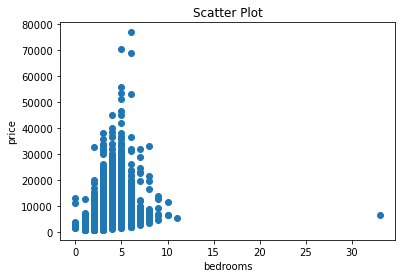

In [17]:
# Scatter plot with day against tip
plt.scatter(data['bedrooms'], data['price'])

# Adding Title to the Plot
plt.title("Scatter Plot")

# Setting the X and Y labels
plt.xlabel('bedrooms')
plt.ylabel('price')

plt.show()

### Removing outliers

In [18]:
data = data[data['bedrooms'] < 15]
data.shape

(21574, 8)

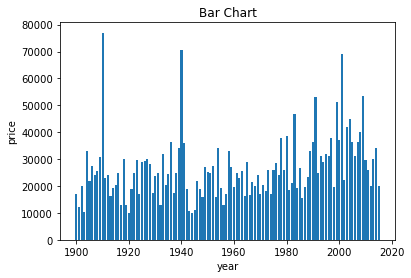

In [19]:
# Bar chart with day against tip
plt.bar(data['yr_built'], data['price'])

plt.title("Bar Chart")

# Setting the X and Y labels
plt.xlabel('year')
plt.ylabel('price')

# Adding the legends
plt.show()

In [20]:
import plotly.express as px
# plotting the scatter chart
fig = px.line(data.head(50), y='yr_built', color='bedrooms')

# showing the plot
fig.show()

In [21]:
## Train Test split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2,random_state=42)

In [22]:
print("x_train dimension: ",x_train.shape)
print("y_train dimension: ",y_train.shape)
print("x_test dimension: ",x_test.shape)
print("y_test dimension: ",y_test.shape)

x_train dimension:  (17260, 7)
y_train dimension:  (17260, 1)
x_test dimension:  (4315, 7)
y_test dimension:  (4315, 1)


In [23]:
assert x_train.shape[0] == y_train.shape[0]

## Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

RandomForestRegressor()

In [25]:
y_pred = rfr.predict(x_test)

In [26]:
rfr.score(x_test, y_test)

0.5755717197106929

## Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [29]:
y_predt = lr.predict(x_test)

In [30]:
lr.score(x_test, y_test)

0.5657046788484963

### Random forest regressor has more accuracy 

## RandomSearchCV

In [31]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

In [32]:
random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [33]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rfr,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [34]:
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [35]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': True}  



In [36]:
randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf= 1, max_features = 'sqrt', max_depth= 7, bootstrap=False) 
randmf.fit( x_train, y_train) 

RandomForestRegressor(bootstrap=False, max_depth=7, max_features='sqrt',
                      min_samples_split=10)

In [37]:
randmf.score(x_test, y_test)

0.5743816220262844

## Grid Search CV

In [38]:
from sklearn.model_selection import GridSearchCV
rf_grid = GridSearchCV(estimator = rfr,param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1)

In [41]:
# rf_grid.fit(x_train, y_train)

# Cannot operate it in my device

# Not being able to run in Google Collab too.